Assignment 4
- Train a CNN for CIFAR-10 with the best hyperparameters possible
- Visualize activations after each Conv filter
- Visualize kernel of each Conv filter
- Which one is working better in CIFAR-10, MaxPooling or AvgPooling or concatination of both.
- Take a Convolutional layer with the appropriate kernel size and load the trained weight/bias into an FC layer (You should think about in what situation you can have convolutional layer like FC layer)

Team members: Vladimir Tsaturyan, Ani Karapetyan

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import random as rand
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split

np.random.seed(1)
torch.manual_seed(2)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transform)
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transform)

trainset_size = len(trainset)
trainset, valset = random_split(trainset, [int(trainset_size*0.9), int(trainset_size*0.1)])

label_map = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
if torch.cuda.is_available():
    avDev = torch.device("cuda")
else:
    avDev = torch.device("cpu")

In [ ]:
class Pooling(nn.Module):
    def __init__(self, kernel_size):
        super(Pooling, self).__init__()
        self.max_pool = nn.MaxPool2d(kernel_size=kernel_size)
        self.avg_pool = nn.AvgPool2d(kernel_size=kernel_size)
    
    def forward(self, x):
        out_max = self.max_pool(x)
        out_avg = self.avg_pool(x)
        return torch.cat([out_max, out_avg], 1)

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, pooling_type):
        super(CNNModel, self).__init__()
        layers = []

        layers.append(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm2d(num_features=32))
        # (32x32x32)

        layers.append(nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm2d(num_features=32))
        # (32x32x32)

        layers.append(self.get_pooling_layer(pooling_type))
        layers.append(nn.Dropout(0.2))
        # (16x16x32) or (16x16x64)

        n_in_channels = 32 if pooling_type != 'MAX_AVG' else 64
        layers.append(nn.Conv2d(in_channels=n_in_channels, out_channels=64, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm2d(num_features=64))
        # (16x16x64)

        layers.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm2d(num_features=64))
        # (16x16x64)

        layers.append(self.get_pooling_layer(pooling_type))
        layers.append(nn.Dropout(0.25))
        # (8x8x64) or (8x8x128)

        n_in_channels = 64 if pooling_type != 'MAX_AVG' else 128
        layers.append(nn.Conv2d(in_channels=n_in_channels, out_channels=128, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm2d(num_features=128))
        # (8x8x128)

        layers.append(nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm2d(num_features=128))
        # (8x8x128)

        layers.append(self.get_pooling_layer(pooling_type))
        layers.append(nn.Dropout(0.3))
        # (4x4x128) or (4x4x256)
        
        flat_dim = 2048 if pooling_type != 'MAX_AVG' else 4096
        layers.append(nn.Linear(flat_dim, 10))
 
        self.layers = nn.ModuleList(layers)
    
    def forward(self, x):
        out = x
        for layer in self.layers[:-1]:
           out = layer(out)
        out = out.view(out.size(0), -1)
        out = self.layers[-1](out)
        return out

    def get_pooling_layer(self, pooling_type):
        if pooling_type == 'MAX':
            pool_layer = nn.MaxPool2d(kernel_size=2)
        elif pooling_type == 'AVG':
            pool_layer = nn.AvgPool2d(kernel_size=2)
        else:
            assert pooling_type == 'MAX_AVG'
            pool_layer = Pooling(kernel_size=2)
        return pool_layer

In [ ]:
class NetworkTrainerAndEvaluator:
    def __init__(self, model, train_dataset, valid_dataset, test_dataset, config):
        self.model = model
        self.loss = nn.CrossEntropyLoss()
        self.optimizer=torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
        self.num_epochs = config['num_epochs']
        batch_size = config['batch_size']       
        self.dset_loaders = {
                              'train': torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True),
                              'val': torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False),
                              'test': torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
                            }

    def accuracy(self, dset):
        self.model.eval()
        loader = self.dset_loaders[dset]
        correct, total = 0, 0
        for images, labels in loader:
            images = images.to(avDev)
            labels = labels.to(avDev)
            images.requires_grad_(False)
            labels.requires_grad_(False)
            outputs = self.model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += images.size(0)
            correct += (predicted == labels).sum().float()
        accuracy = 100. * correct / total
        return accuracy.item()

    def get_confusion_matrix(self, dset="test"):
        self.model.eval()
        loader = self.dset_loaders[dset]
        pred_list=torch.zeros(0,dtype=torch.long, device='cpu')
        lbl_list=torch.zeros(0,dtype=torch.long, device='cpu')
        for images, labels in loader:
            images = images.to(avDev)
            labels = labels.to(avDev)
            images.requires_grad_(False)
            labels.requires_grad_(False)
            outputs = self.model(images)
            _, predicted = torch.max(outputs.data, 1)
            pred_list=torch.cat([pred_list, predicted.view(-1).cpu()])
            lbl_list=torch.cat([lbl_list, labels.view(-1).cpu()])

        cm = confusion_matrix(lbl_list.numpy(), pred_list.numpy())
        return cm

    def train(self, tboard_writer=None):
        loss_values = []
        train_accuracies = []
        val_accuracies = []
        for epoch in range(self.num_epochs):
            self.model.train()
            running_loss = 0.0
            for i, (images, labels) in enumerate(self.dset_loaders["train"]):
                images = images.to(avDev)
                labels = labels.to(avDev)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.loss(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item() * images.size(0)   

            loss_values.append(running_loss / len(self.dset_loaders["train"].dataset))
                    
            train_accuracy = self.accuracy(dset='train')
            val_accuracy = self.accuracy(dset='val')   
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            print('Epoch: {}. Loss: {}. Train accuracy: {}. Validation accuracy: {}'
                      .format(epoch + 1, loss_values[-1], train_accuracy, val_accuracy))
            
            if tboard_writer is not None:
                tboard_writer.add_scalar('training accuracy', train_accuracy, epoch + 1)
                tboard_writer.add_scalar('validation accuracy', val_accuracy, epoch + 1)
                tboard_writer.add_scalar('loss', loss_values[-1], epoch + 1)
        return loss_values, train_accuracies, val_accuracies

In [ ]:
def train_cnn_model(config):
    """
    Trains a CNN model and plots the learning curve, training and validation accuracies,
    reports test accuracy, as well as plots the confusion matrix.
    """

    model = CNNModel(pooling_type=config['pooling_type']).to(avDev)
    trainer_and_eval = NetworkTrainerAndEvaluator(model, trainset, valset, testset, config)
    loss_values, train_acc, val_acc = trainer_and_eval.train(tboard_writer=None)

    print('Test accuracy: ', trainer_and_eval.accuracy('test'))

    num_epochs = config['num_epochs']
    x = np.linspace(1, num_epochs, num_epochs)
    plt.plot(x, loss_values)
    plt.xlabel("#epochs")
    plt.ylabel('Loss')
    plt.show()

    x = np.linspace(1, num_epochs, num_epochs)
    plt.plot(x, train_acc, label='Training accuracy')
    plt.plot(x, val_acc, label='Validation accuracy')
    plt.xlabel("#epochs")
    plt.legend()
    plt.show()

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cm = trainer_and_eval.get_confusion_matrix()
    cm = ConfusionMatrixDisplay(cm, display_labels=label_map)
    cm.plot(ax=ax, xticks_rotation='vertical')
    ax.tick_params(labelsize=15)

    return model

In [ ]:
config = {
    'batch_size': 64,
    'num_epochs': 20,
    'learning_rate': 2*1e-3,
    'weight_decay': 1e-5,
    'pooling_type': 'MAX'
}

Epoch: 1. Loss: 1.4145708813137479. Train accuracy: 69.51333618164062. Validation accuracy: 66.83999633789062
Epoch: 2. Loss: 0.8793746018621657. Train accuracy: 76.08444213867188. Validation accuracy: 72.91999816894531
Epoch: 3. Loss: 0.7078224511464437. Train accuracy: 79.63333129882812. Validation accuracy: 75.47999572753906
Epoch: 4. Loss: 0.6146144277148776. Train accuracy: 83.4111099243164. Validation accuracy: 77.97999572753906
Epoch: 5. Loss: 0.5542786234855652. Train accuracy: 86.0999984741211. Validation accuracy: 80.1199951171875
Epoch: 6. Loss: 0.5055512014389039. Train accuracy: 88.37110900878906. Validation accuracy: 80.79999542236328
Epoch: 7. Loss: 0.4663493342505561. Train accuracy: 89.37333679199219. Validation accuracy: 81.86000061035156
Epoch: 8. Loss: 0.4323692918565538. Train accuracy: 90.36444854736328. Validation accuracy: 82.29999542236328
Epoch: 9. Loss: 0.39943354020118715. Train accuracy: 92.53555297851562. Validation accuracy: 83.22000122070312
Epoch: 10. L

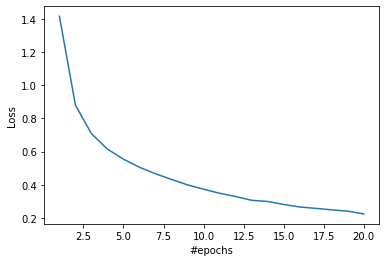

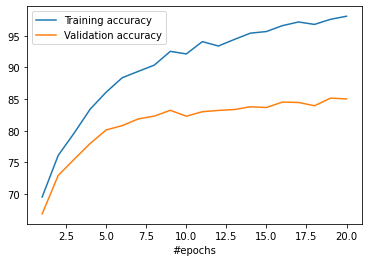

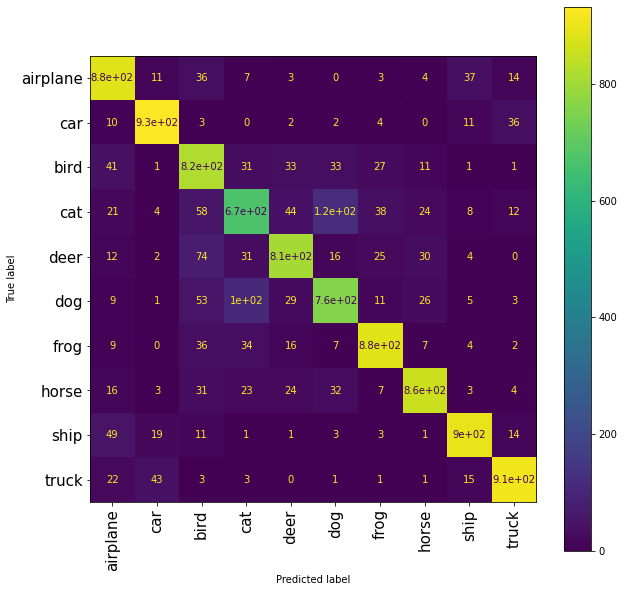

In [ ]:
config['pooling_type'] = 'MAX'
model1 = train_cnn_model(config)

Epoch: 1. Loss: 1.367080914009942. Train accuracy: 66.49333190917969. Validation accuracy: 64.45999908447266
Epoch: 2. Loss: 0.8880756312688192. Train accuracy: 76.11555480957031. Validation accuracy: 73.63999938964844
Epoch: 3. Loss: 0.7178047903908623. Train accuracy: 80.55110931396484. Validation accuracy: 76.5999984741211
Epoch: 4. Loss: 0.6199908792442745. Train accuracy: 84.77777862548828. Validation accuracy: 80.1199951171875
Epoch: 5. Loss: 0.5474348474926418. Train accuracy: 85.65555572509766. Validation accuracy: 79.97999572753906
Epoch: 6. Loss: 0.49934604456424714. Train accuracy: 88.32888793945312. Validation accuracy: 81.37999725341797
Epoch: 7. Loss: 0.4552322711308797. Train accuracy: 90.34222412109375. Validation accuracy: 82.37999725341797
Epoch: 8. Loss: 0.4262814416037665. Train accuracy: 90.85778045654297. Validation accuracy: 82.5
Epoch: 9. Loss: 0.38708417683177526. Train accuracy: 92.37110900878906. Validation accuracy: 83.79999542236328
Epoch: 10. Loss: 0.36752

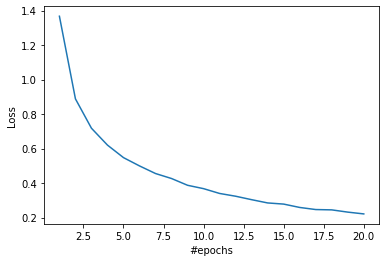

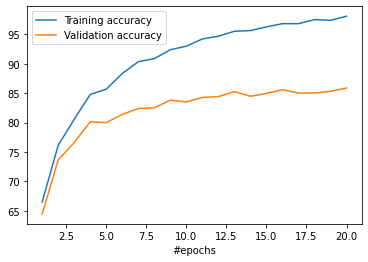

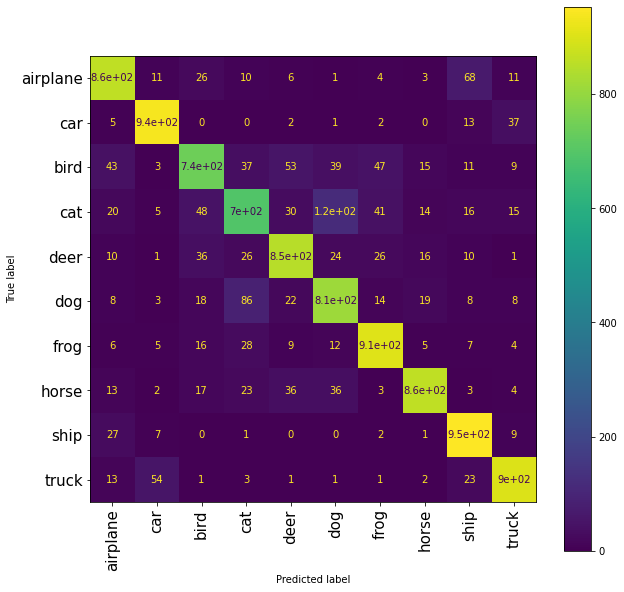

In [ ]:
config['pooling_type'] = 'AVG'
model2 = train_cnn_model(config)

Epoch: 1. Loss: 1.6288465388827853. Train accuracy: 66.55333709716797. Validation accuracy: 65.22000122070312
Epoch: 2. Loss: 0.9252454347451528. Train accuracy: 76.74888610839844. Validation accuracy: 72.95999908447266
Epoch: 3. Loss: 0.7206356776343451. Train accuracy: 79.83111572265625. Validation accuracy: 76.05999755859375
Epoch: 4. Loss: 0.6223356252670288. Train accuracy: 83.0955581665039. Validation accuracy: 78.5
Epoch: 5. Loss: 0.5432800911373562. Train accuracy: 87.16444396972656. Validation accuracy: 80.69999694824219
Epoch: 6. Loss: 0.48008023700184294. Train accuracy: 87.97111511230469. Validation accuracy: 81.04000091552734
Epoch: 7. Loss: 0.43710816378063627. Train accuracy: 91.38666534423828. Validation accuracy: 82.45999908447266
Epoch: 8. Loss: 0.3874864671919081. Train accuracy: 91.17111206054688. Validation accuracy: 81.72000122070312
Epoch: 9. Loss: 0.3558751286824544. Train accuracy: 93.04000091552734. Validation accuracy: 82.47999572753906
Epoch: 10. Loss: 0.318

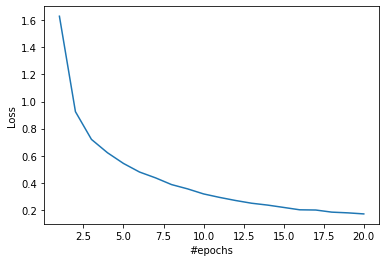

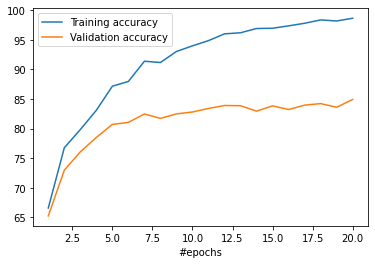

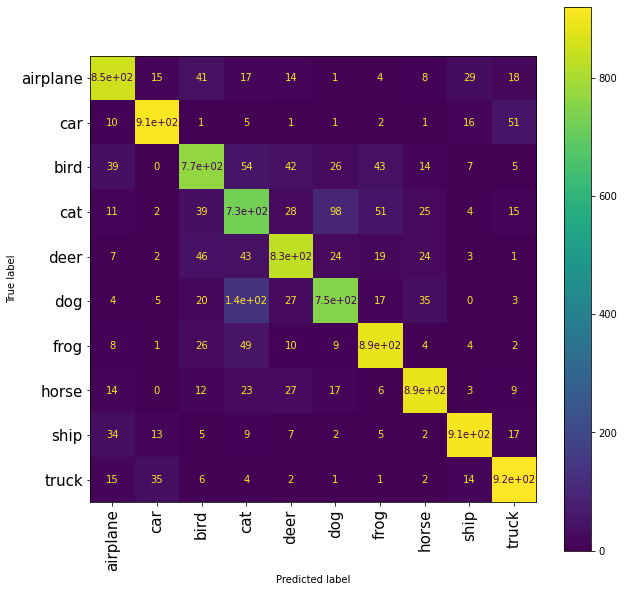

In [ ]:
config['pooling_type'] = 'MAX_AVG'
model3 = train_cnn_model(config)

In [ ]:
# We see that average pooling works better (85.3% test accuracy) than max pooling (84.3% test accuracy)
# or concatenation of both (84.5% test accuracy).
model = model2

In [ ]:
# Visualize kernels of each filter of each conv layer.

def plot_filters(filters, n_kernels):
    """
    Plots the first few kernels of the set of kernels of the given @filters.
    """
    from math import sqrt
    n_rows = n_cols = int(sqrt(n_kernels))
    n_kernels = n_rows**2
    filters = filters.view(-1, 3, 3)
    if filters.size(0) > n_kernels:
      filters = filters[:n_kernels]    
    _, axs = plt.subplots(n_rows, n_cols, figsize=(20,20))
    for i in range(n_rows):
      for j in range(n_cols):
        axs[i,j].axis('off')
    for kernel, ax in zip(filters, axs.ravel()):
      kernel = kernel.cpu().numpy()
      kernel_img = np.clip(kernel, 0, 1)
      ax.imshow(kernel_img)
    plt.show()

def plot_all_filters(model):
    """
    Plots the kernels of each filter of all convolution layers of the @model.
    """
    for layer in model.layers:
      if isinstance(layer, nn.Conv2d):
        print(layer)
        plot_filters(layer.weight.data, n_kernels=100)

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


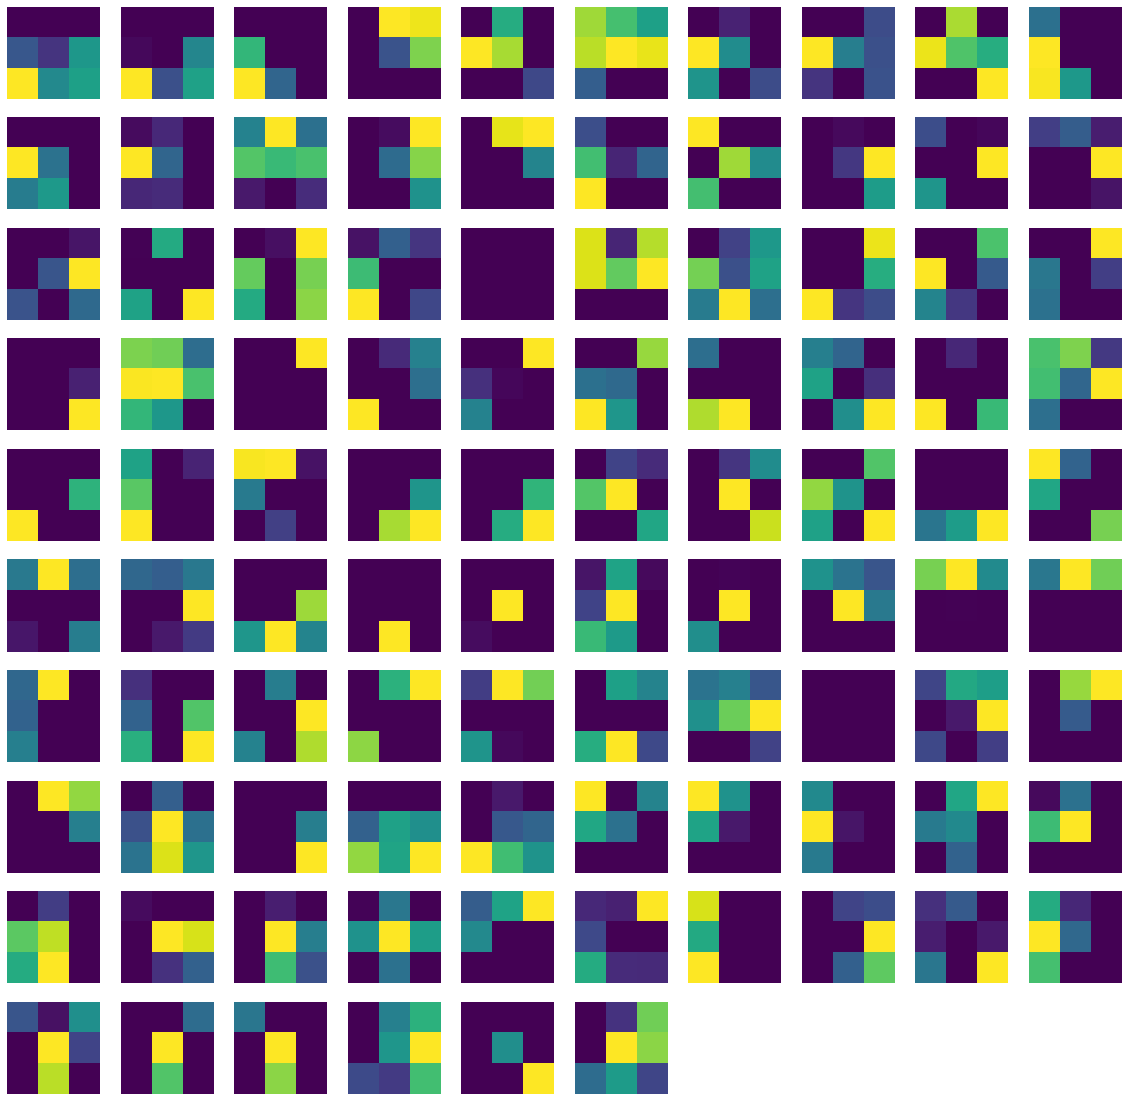

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


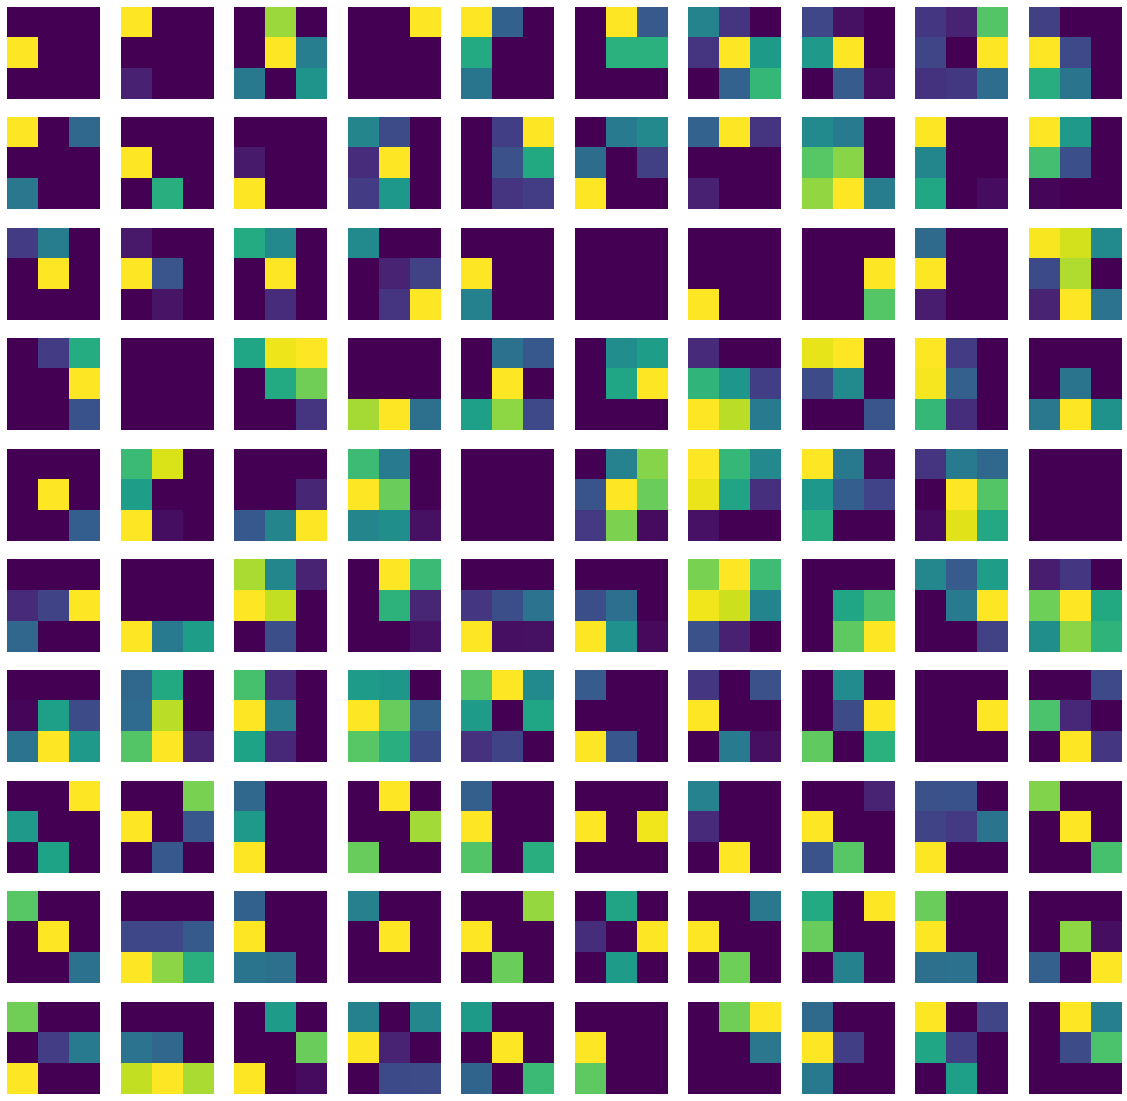

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


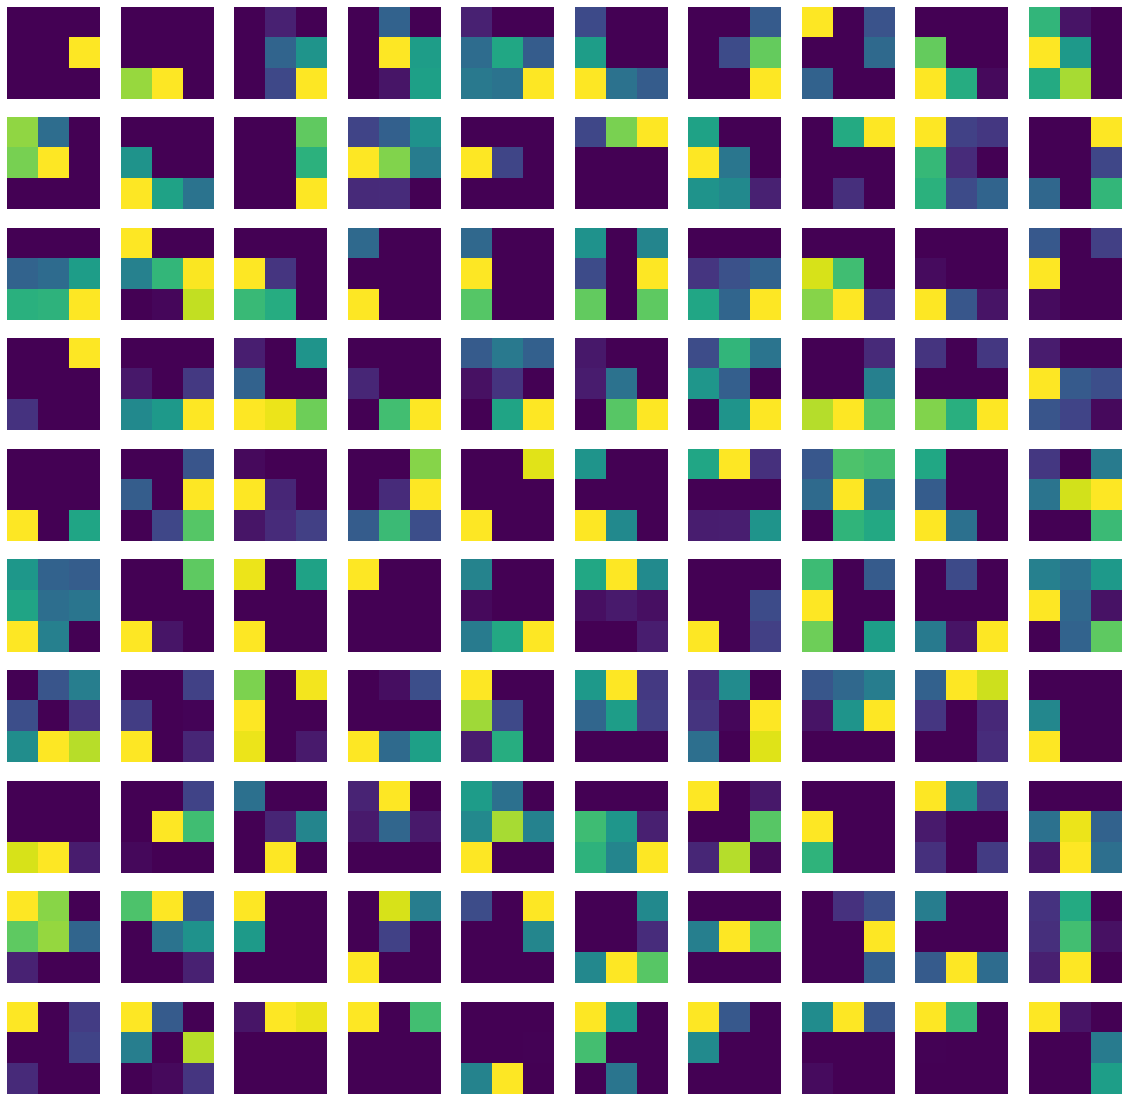

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


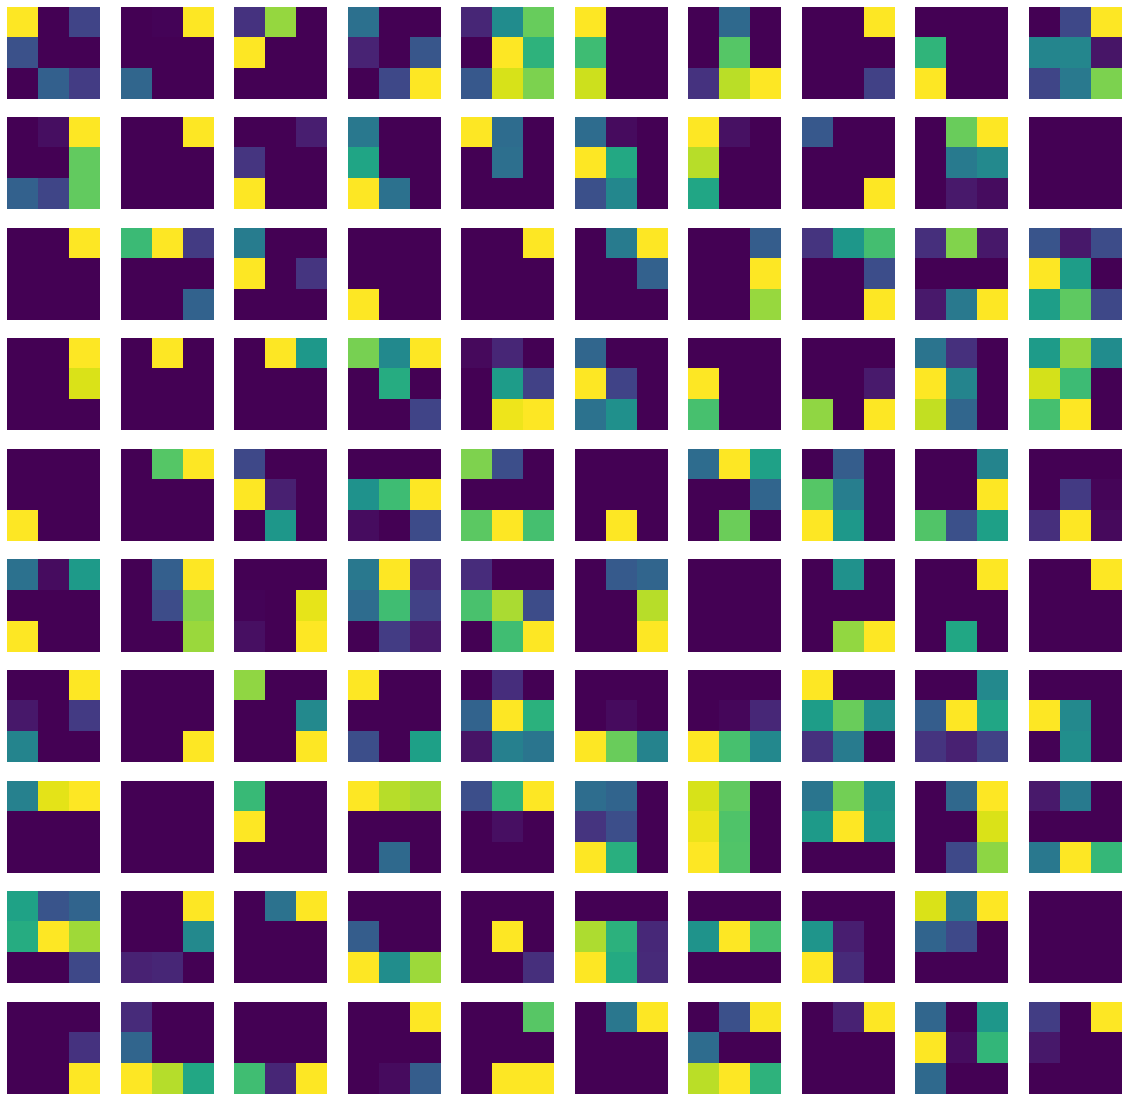

Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


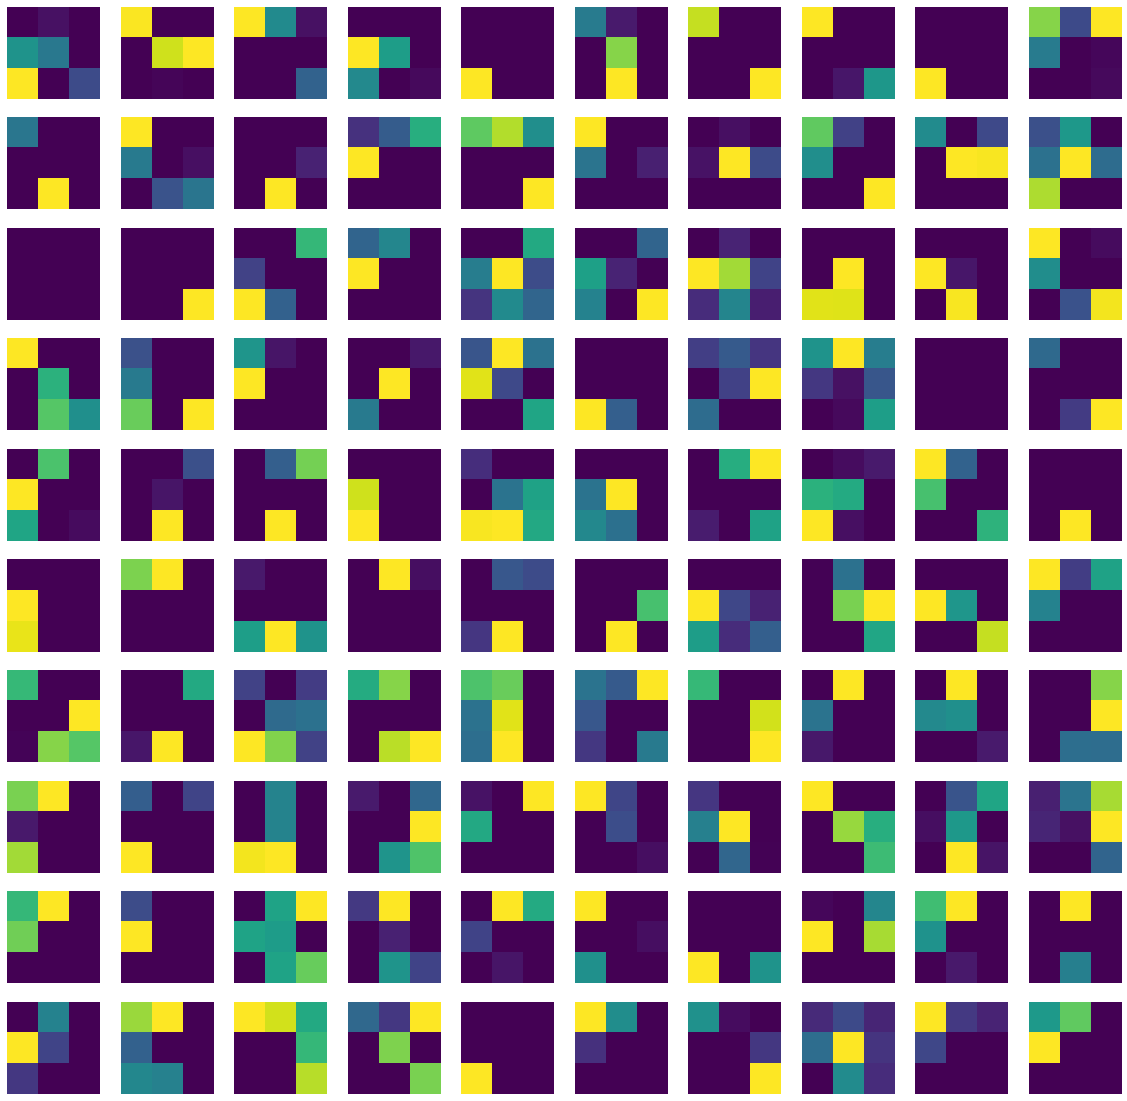

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


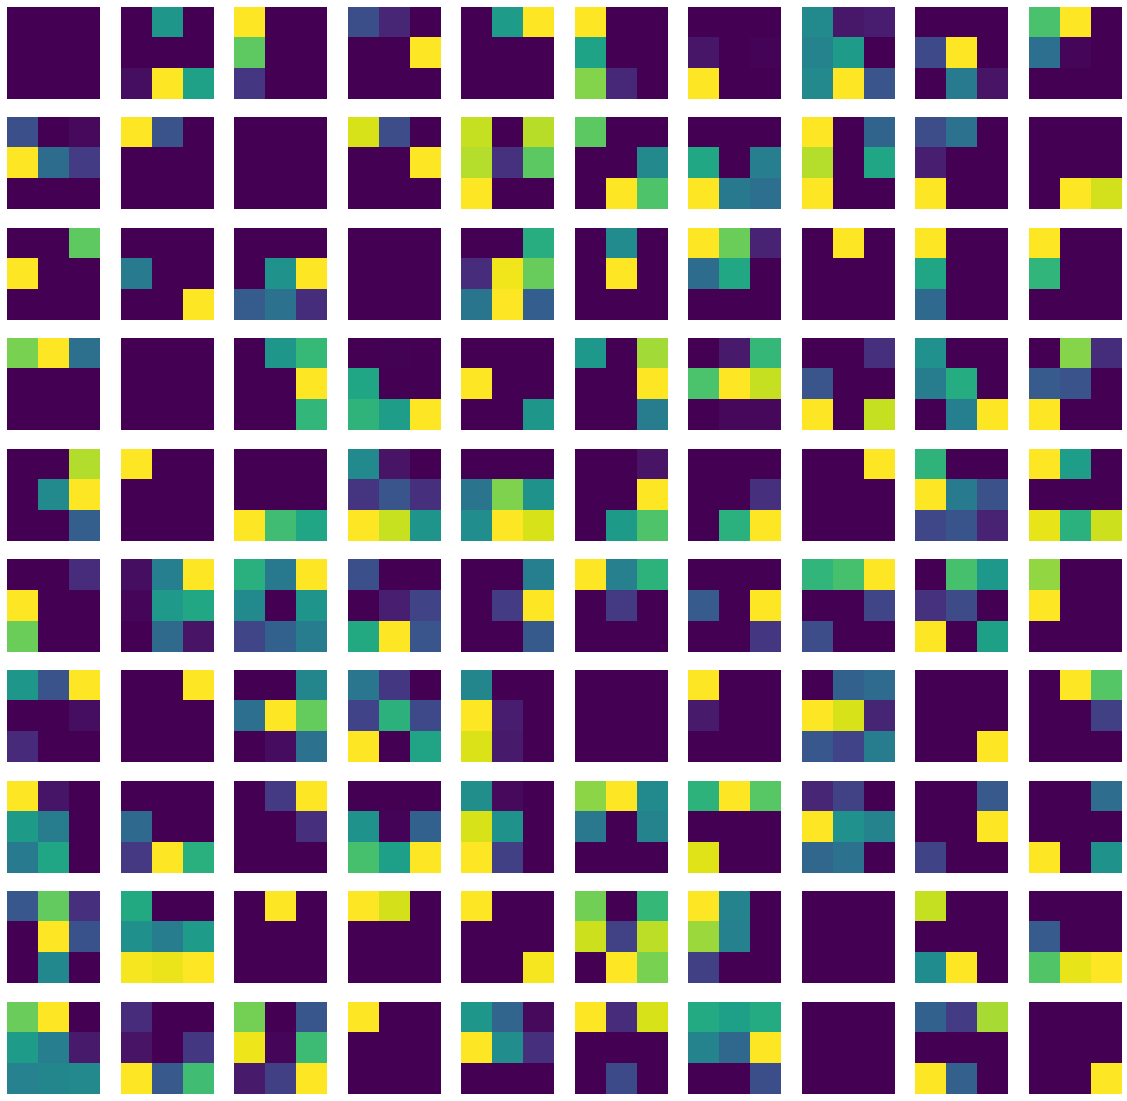

In [ ]:
plot_all_filters(model)

In [ ]:
# Visualize activations after each Conv filter.

def plot_activation_maps(act_maps):
    """
    Plots each activation map (single channel) of the given set @act_maps as a single image.
    """
    num_act_maps = act_maps.size(0)
    _, axs = plt.subplots(8, num_act_maps//8, figsize=(20,20))
    act_maps = act_maps.cpu().numpy()
    for act_map, ax in zip(act_maps, axs.ravel()):
      act_map_img = np.clip(act_map, 0, 1)
      ax.axis('off')
      ax.imshow(act_map_img)
    plt.show()

def plot_all_activation_maps(model, input):
    """
    Plots the activation maps of the @model after each convolution layer for the given @input.
    """
    with torch.no_grad():
      out = input
      for layer in model.layers[:-1]:
        out = layer(out)
        if isinstance(layer, nn.Conv2d):
          print(layer)
          plot_activation_maps(out[0])

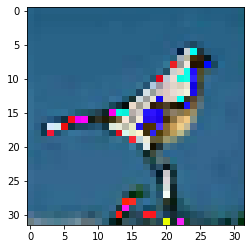

In [ ]:
img = trainset[2][0]
_to_pil = transforms.ToPILImage()
plt.imshow(_to_pil(img))

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


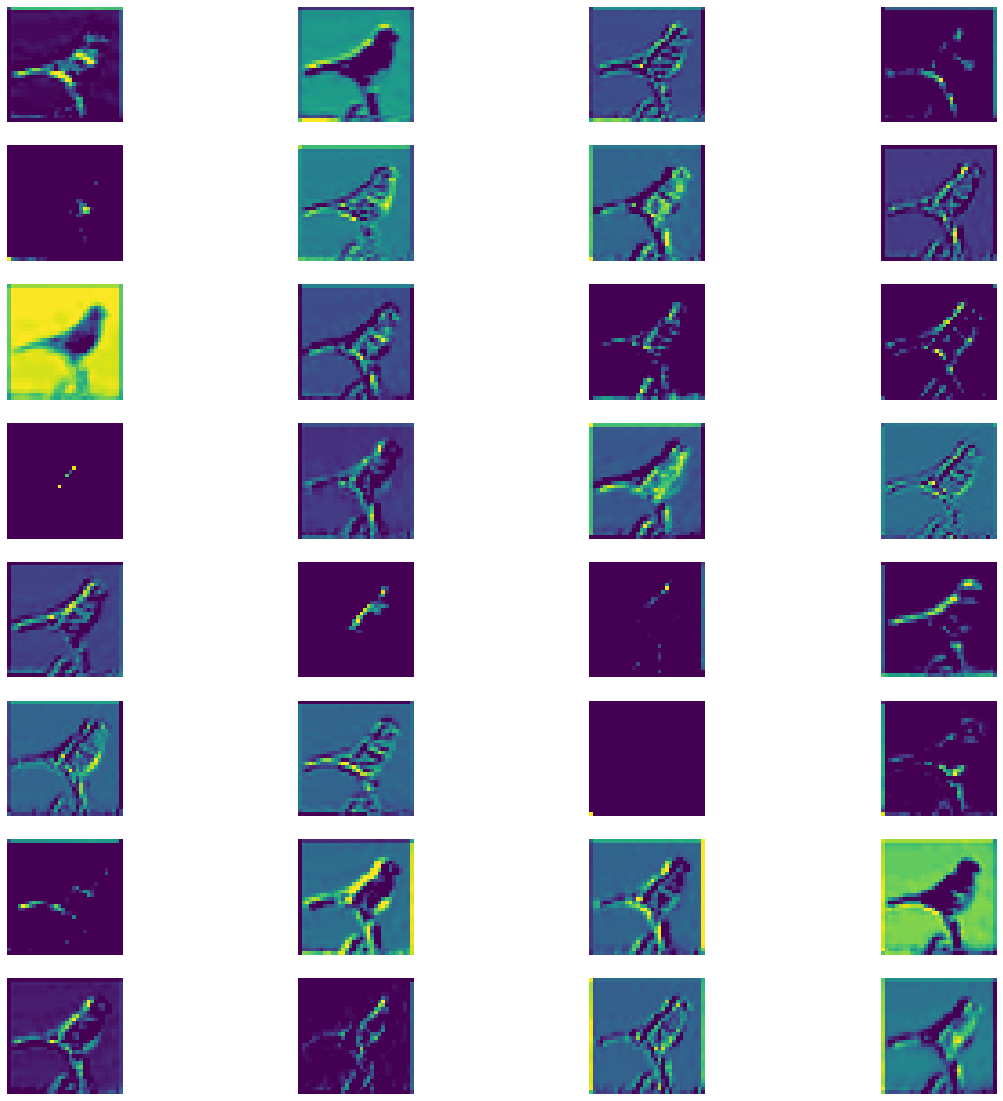

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


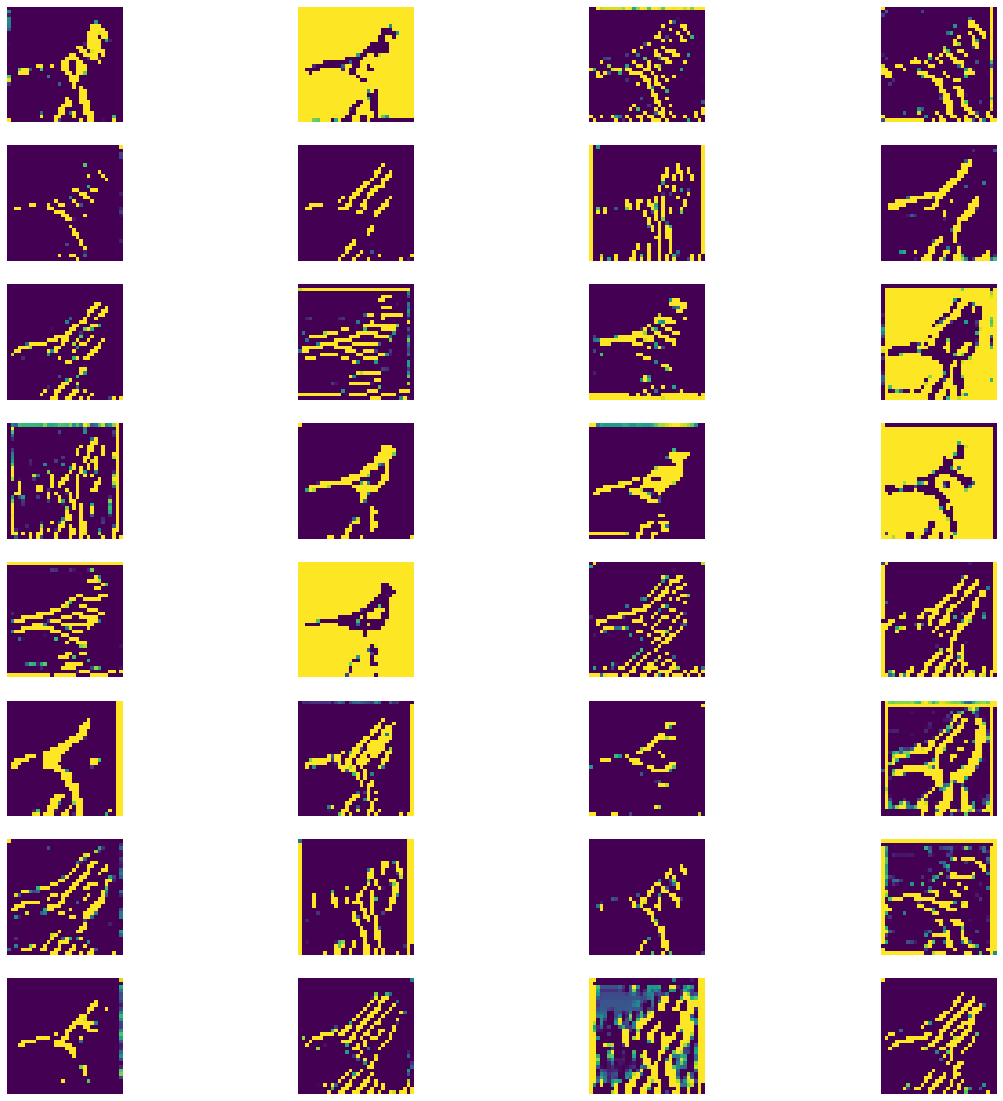

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


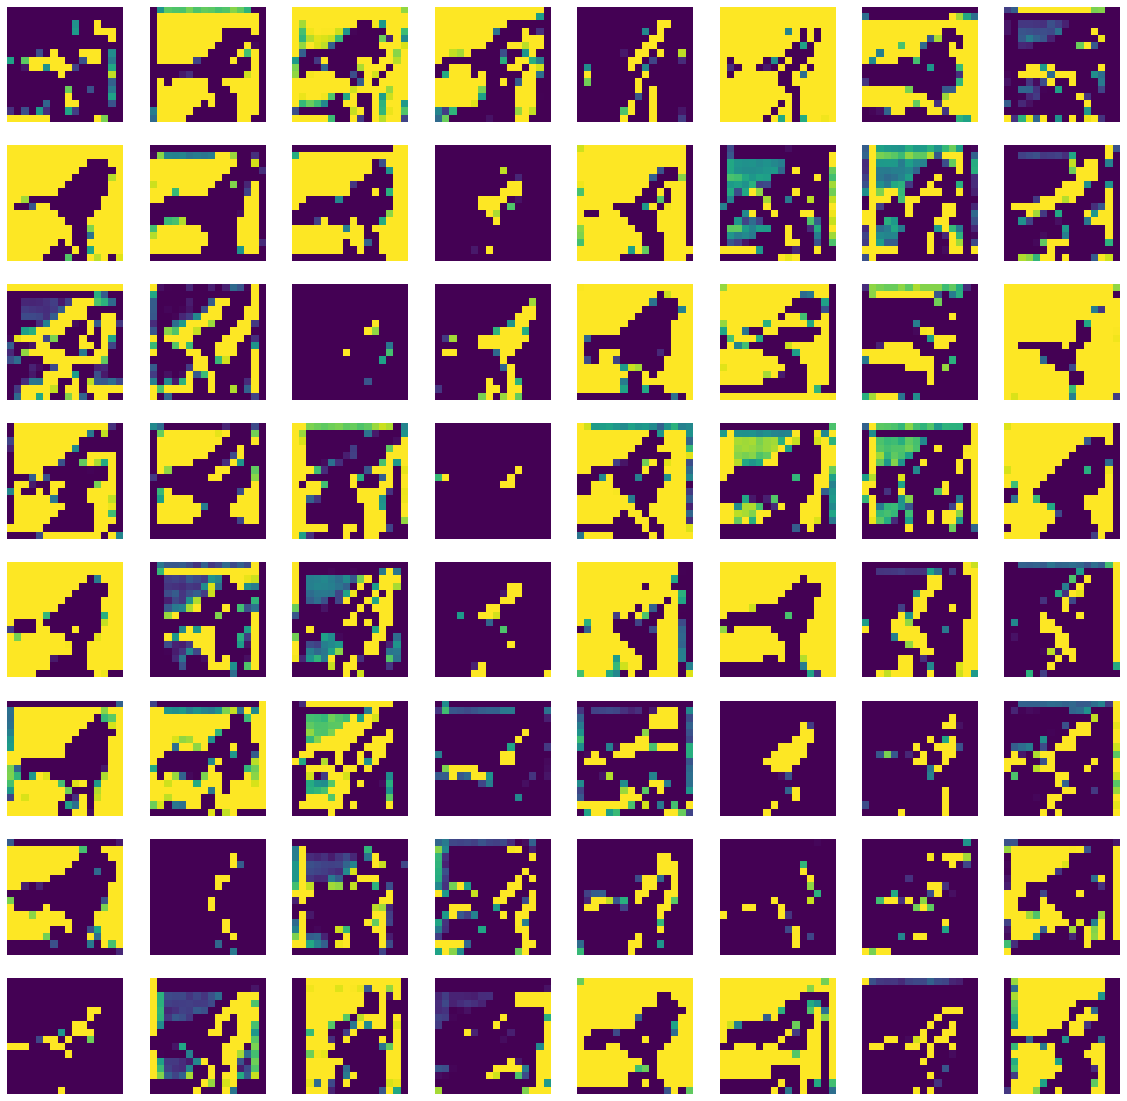

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


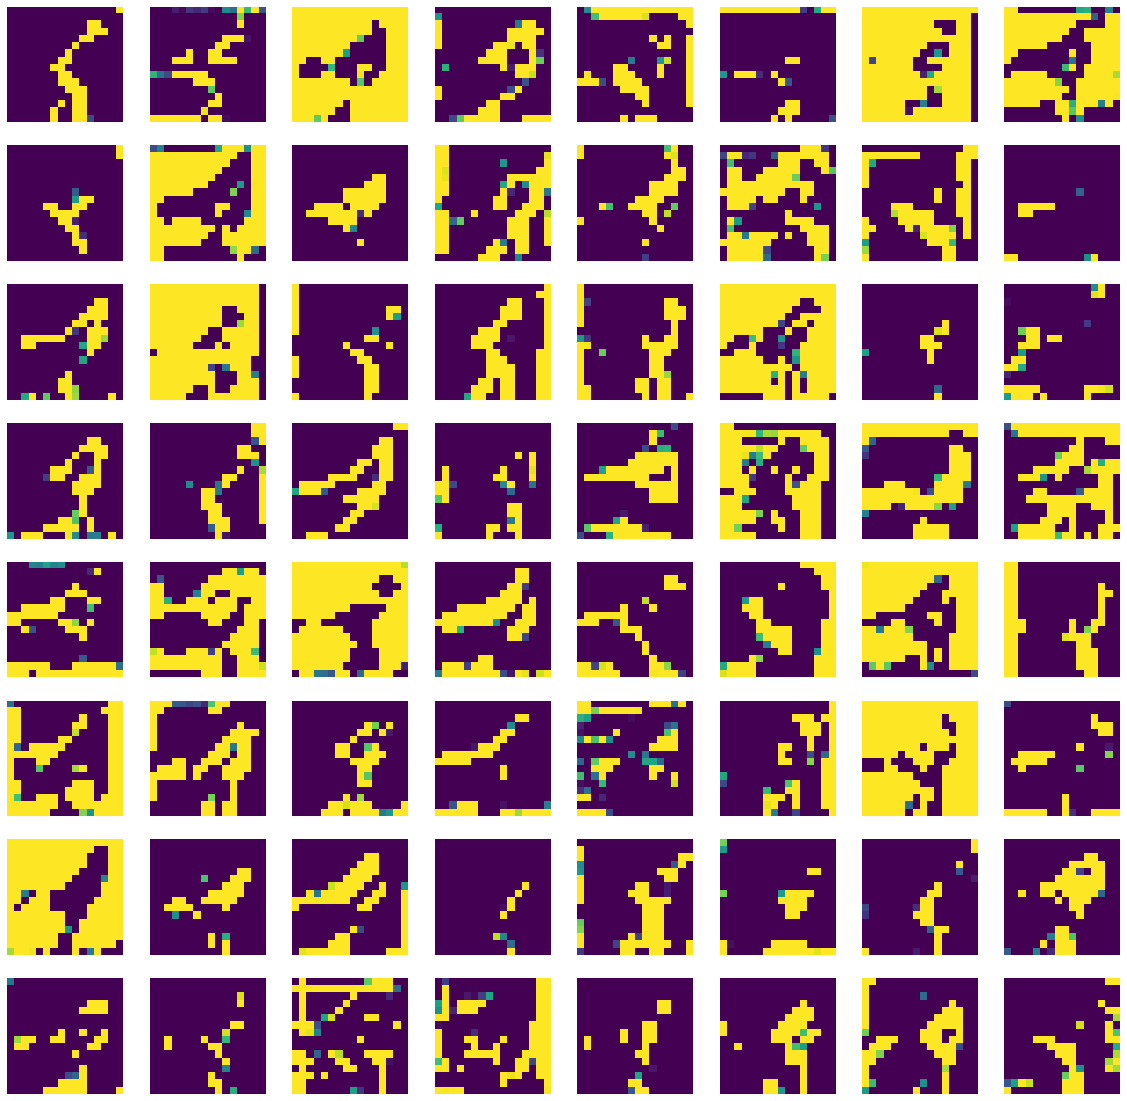

Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


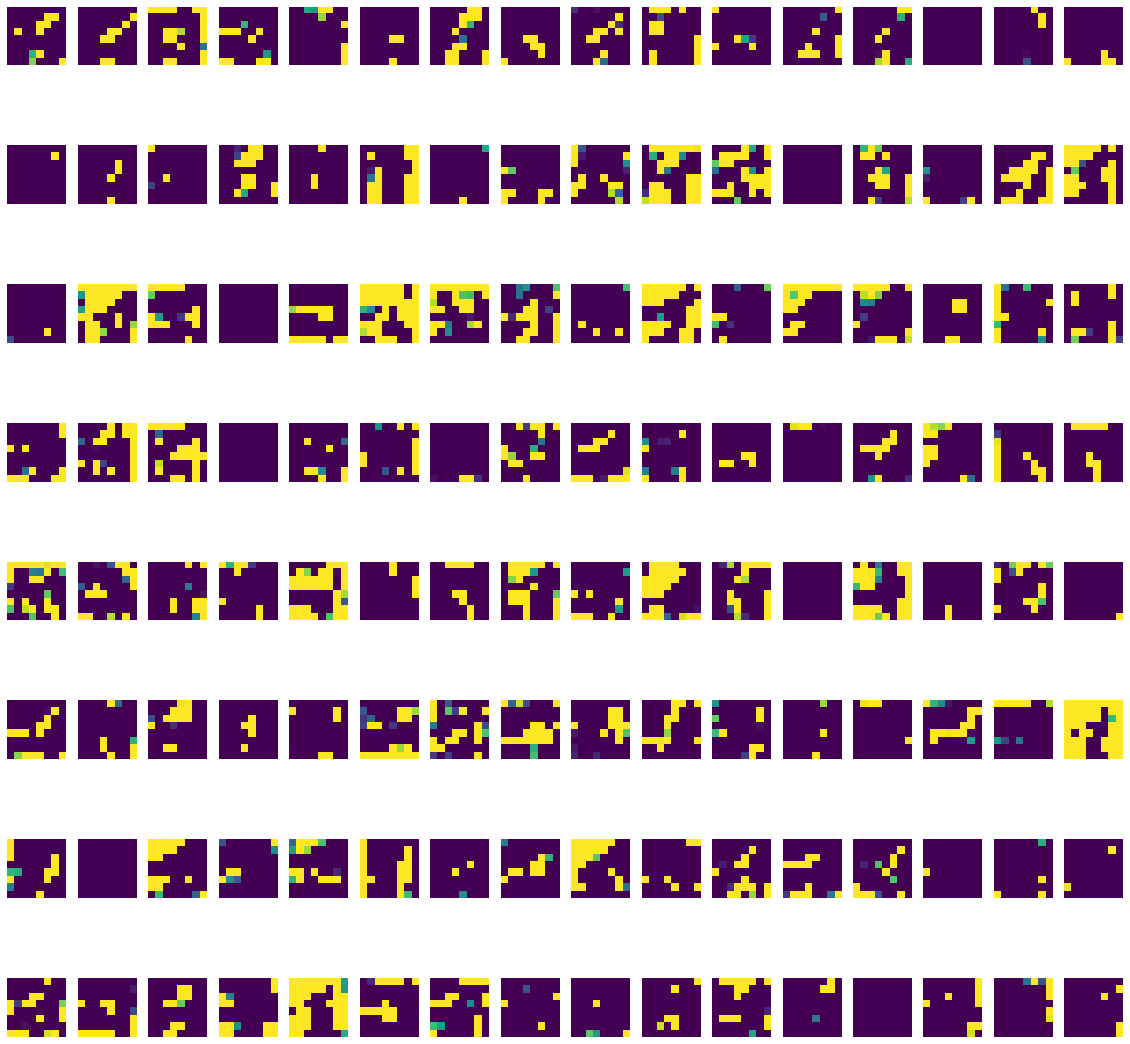

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


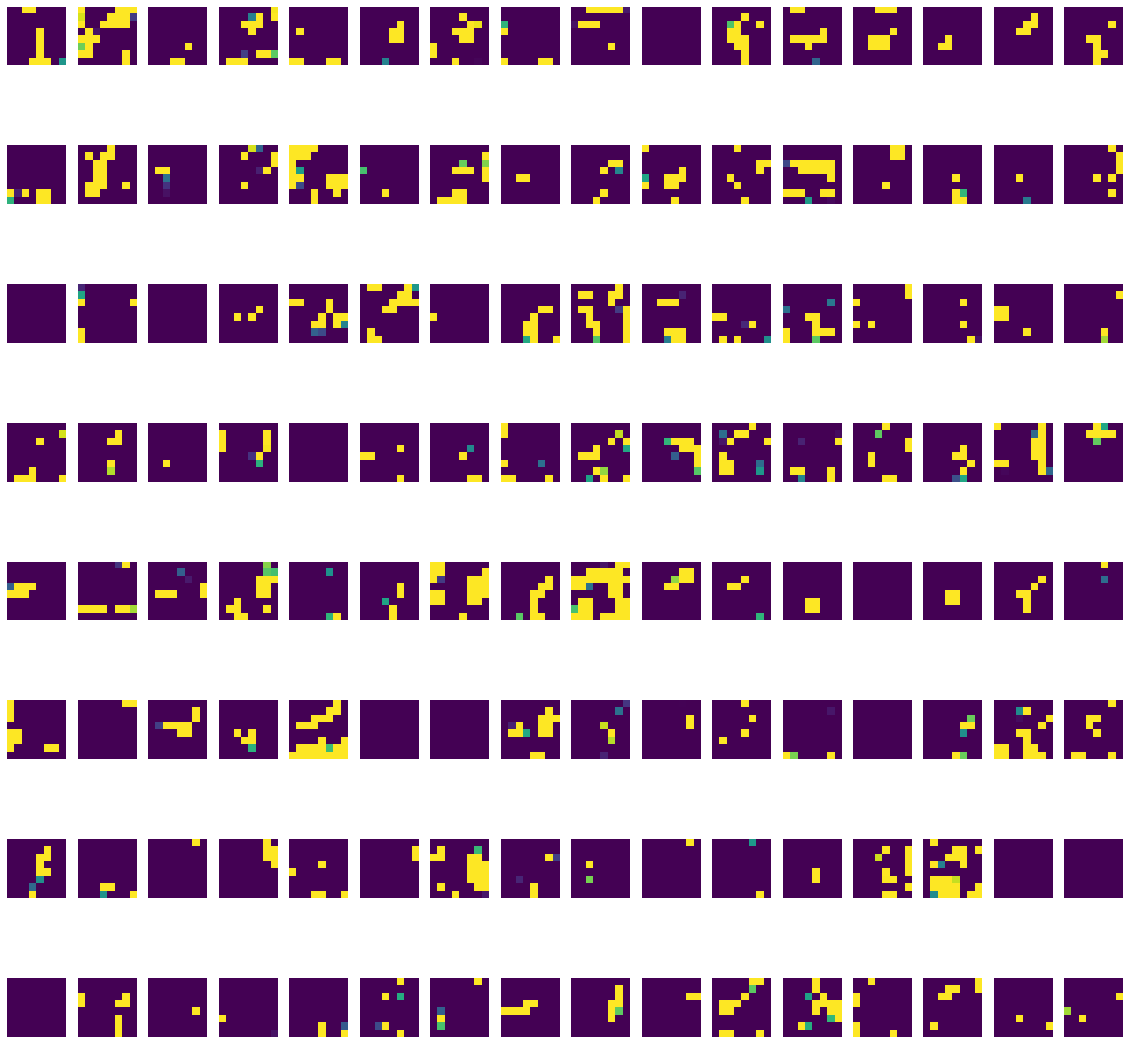

In [ ]:
img = trainset[2][0]
img = torch.unsqueeze(img, dim=0).to(avDev)
plot_all_activation_maps(model, img)

- Take a Convolutional layer with the appropriate kernel size and load the trained weight/bias into an FC layer (You should think about in what situation you can have convolutional layer like FC layer)

It is known that a fully connected layer is a special case of the convolutional layer (https://www.arxiv-vanity.com/papers/1606.06160/). On the other hand, one can show that convolution can be made by matrix multiplication (https://www.arxiv-vanity.com/papers/1712.01252/). Thus, one can transform the convolutional layer to fully connected (https://www.arxiv-vanity.com/papers/1712.01252/). Such a transformation requires to modify the input data (not just reshaping it). The special case which doesn't need data transformation is if the kernel size is equal to the input size.
You can see the example below.

In [ ]:
batch_size = 1
loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
image, _ = iter(loader).next()

n = 15
image_size = image.size()
flat_dim = image_size[1]*image_size[2]*image_size[3]
conv = nn.Conv2d(in_channels=3, out_channels=n, kernel_size=32, stride=1)
conv_params = conv.state_dict()
fc = nn.Linear(flat_dim, n)
fc.load_state_dict({"weight":conv_params["weight"].view(n, flat_dim), "bias":conv_params["bias"]})

res_img_fc = fc(image.view(1, flat_dim))
res_img_conv = conv(image).view(1, n)
print("res_img_fc: ", res_img_fc[0].data)
print("res_img_conv: ", res_img_conv[0].data)
# The resulting tensors are almost the same (up to numerical error).
print("diff: ", (res_img_fc - res_img_conv)[0].data)

res_img_fc:  tensor([ 0.3311,  0.1396, -0.1238,  0.3757, -0.0556,  0.2388, -0.0255,  0.3801,
        -0.3626,  0.3350, -0.1196,  0.1327, -0.1787, -0.1312,  0.2851])
res_img_conv:  tensor([ 0.3311,  0.1396, -0.1238,  0.3757, -0.0556,  0.2388, -0.0255,  0.3801,
        -0.3626,  0.3350, -0.1196,  0.1327, -0.1787, -0.1312,  0.2851])
diff:  tensor([ 5.3644e-07,  1.1921e-07, -1.7136e-07,  3.2783e-07, -2.2352e-08,
         8.9407e-08, -2.6450e-07, -2.0862e-07, -2.9802e-08,  2.9802e-08,
        -5.9605e-08, -8.9407e-08,  4.7684e-07,  3.5763e-07,  5.9605e-08])
